In [1]:
import numpy as np
import torch
# 导入PyTorch内置的mnist数据集
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
# 定义超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [3]:
# 3.下载数据并对数据进行预处理
# 定义预处理函数，这些预处理一次存放在Compose函数中
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True,transform=transform,download=True)
test_dataset = mnist.MNIST('./data',train=False,transform=transform)
# dataloader是一个可迭代对象，可以像使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=test_batch_size,shuffle=False)

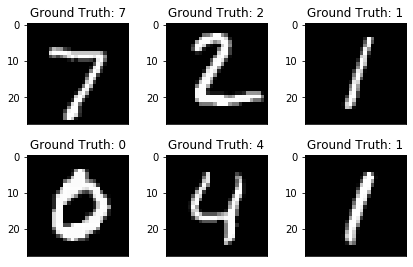

In [4]:
# 3.2.3 可视化源数据
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx, (example_data,example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.xticks([])

In [5]:
# 3.2.4 构建模型
# （1）构建网络
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数功能是将网络层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
# (2)实例化gpu
# 检测是否有可用的gpu，有则使用，否则使用cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28*28, 300, 100, 10)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [7]:
# 3.2.5训练模型
# 1.训练模型
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0),-1)
        # 前向计算
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上校验结果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模型
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_losses.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, \
           Test Acc: {:.4f}'.format(epoch, train_loss/len(train_loader), train_acc/len(train_loader),
                                    eval_loss/len(test_loader), eval_acc/len(test_loader)))


epoch: 0, Train Loss: 1.0201, Train Acc: 0.7857, Test Loss: 0.5457,            Test Acc: 0.9009
epoch: 1, Train Loss: 0.4812, Train Acc: 0.8998, Test Loss: 0.3520,            Test Acc: 0.9260
epoch: 2, Train Loss: 0.3506, Train Acc: 0.9203, Test Loss: 0.2757,            Test Acc: 0.9381
epoch: 3, Train Loss: 0.2854, Train Acc: 0.9315, Test Loss: 0.2259,            Test Acc: 0.9459
epoch: 4, Train Loss: 0.2430, Train Acc: 0.9401, Test Loss: 0.1967,            Test Acc: 0.9512
epoch: 5, Train Loss: 0.2235, Train Acc: 0.9449, Test Loss: 0.1973,            Test Acc: 0.9524
epoch: 6, Train Loss: 0.2191, Train Acc: 0.9460, Test Loss: 0.1921,            Test Acc: 0.9528
epoch: 7, Train Loss: 0.2166, Train Acc: 0.9465, Test Loss: 0.1908,            Test Acc: 0.9532
epoch: 8, Train Loss: 0.2152, Train Acc: 0.9471, Test Loss: 0.1871,            Test Acc: 0.9531
epoch: 9, Train Loss: 0.2118, Train Acc: 0.9476, Test Loss: 0.1874,            Test Acc: 0.9545
epoch: 10, Train Loss: 0.2109, Train Acc

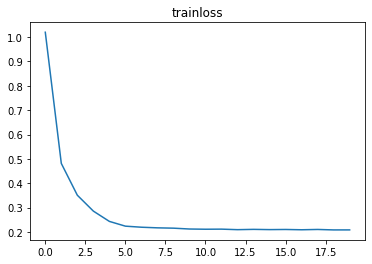

In [9]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'])

In [2]:
# 3.3构建神经网络
# 在Sequential基础上，通过字典的形式添加每一层，并且设置单独的层名称。
# 以下是采用字典方式构建网络的一个示例代码
# 3.3.1 构建网络层
import torch
class Net(torch.nn.Module):
    def __init__(self):
        super(Net4,self).__init__()
        self.conv = torch.nn.Sequential(
            OrderedDict(
                [("conv1", torch.nn.Conv2d(3,32,3,1,1)),
                 ("relu1", torch.nn.ReLU()),
                 ("pool", torch.nn.MaxPool2d(2))]
            ))
        self.dense = torch.nn.Sequential(
            OrderedDict(
                [("dense1", torch.nn.Linear(32*3*3,128)),
                 ("relu2", torch.nn.ReLU()),
                 ("dense2", torch.nn.Linear(128,10))]
            ))
        

In [3]:
# 在forward函数中，有些层来自nn.Module，也可以使用nn.functional定义。
# 来自nn.Module的需要实例化，而使用nn.functional定义的可以直接使用
# 3.3.3 反向传播
# 3.3.4 训练模型

In [4]:
# 3.5优化器
#（1）建立优化器实例
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

NameError: name 'model' is not defined

In [5]:
# (2)前向传播
out = model(img)
loss = criterion(out, label)

NameError: name 'model' is not defined

In [6]:
# (3)清空梯度
optimizer.zero_grad()
# (4)反向传播
loss.backward()
# (5)更新参数
optimizer.step()

NameError: name 'optimizer' is not defined

In [7]:
# 3.6 动态修改学习率参数
# 3.2节中动态修改学习率参数

In [9]:
# 3.7 优化器比较
# (1)导入需要的模块
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

In [10]:
# （2）生成数据
# 生成训练数据
# torch.unsqueeze() 将一维变为二维 
x = torch.unsqueeze(torch.linspace(-1,1,1000), dim=1)
# 增加噪声
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))
torch_dataset = Data.TensorDataset(x,y)
# 得到一个带批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# (3)构建神经网络
class Net(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1,20)
        self.predict = torch.nn.Linear(20,1)
    # 前向传播
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [13]:
# (4)使用多种优化器
net_SGD = Net()
net_Momentum = Net()
net_RMSProp = Net()
net_Adam = Net()
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9,0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

In [14]:
# (5)训练模型
loss_func = torch.nn.MSELoss()
loss_his = [[],[],[],[]] # 记录损失
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt, l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x) # 得到每一个网络的输出
            loss = loss_func(output, batch_y) # 计算每一个网络的损失
            opt.zero_grad() # 为下次训练将梯度清零
            loss.backward() # 反向传播， 计算梯度
            opt.step() # 更新参数
            l_his.append(loss.data.numpy()) # 记录损失
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']

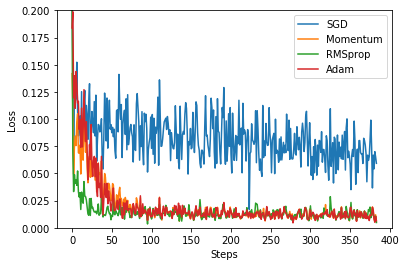

In [16]:
# (6)可视化结果
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label = labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0,0.2))
plt.show()